# Projekt PSI
Analiza 5: co jest silniejsze w niespójnym warunku (inc): dźwięk vs obraz? 
a może negatywne vs pozytywne? 
(np. nieważne czy negatywny jest dźwięk czy obraz, ważne że co najmniej jedno jest negatywne i całość też jest negatywna)


## Loading data


In [26]:
%matplotlib inline
import os
import pandas
import matplotlib.pyplot as plt
import numpy as np
# import seaborn

# files that we use, additional windows path handling for windows douche bags
if os.name == 'nt':
    bitalino_filename = '..\\data\\bitalino\\1107_opensignals_prawestanowisko_2019-04-19_09-11-49.txt'
    IADS2_filename = '..\\data\\IADS2.csv'
    df_source_filename = "..\\data\\procedura\\"
    IAPS_filename = '..\\data\\IAPS.csv'
else:
    bitalino_filename = '../data/2019-afcai-spring/bitalino/1107_opensignals_prawestanowisko_2019-04-19_09-11-49.txt'
    IADS2_filename = '../data/IADS2.csv'
    df_source_filename = "../data/2019-afcai-spring/procedura/"
    IAPS_filename = '../data/IAPS.csv'
    
print("Filenames Loaded")

Filenames Loaded


Ten sposób jakiś upośledzony jest, można to jakoś mądrzej zrobić. A i w sumie to nam to chyba nie potrzebne xd
ODP: na razie to nie będzie potrzebne, tym można się później zajać jako dodatkowa 
rzecz/rozwinięcie projektu (красный лиса и зелёный лиса, приветствие! который объясняет этого идиота.)

In [27]:
hr = pandas.read_csv(bitalino_filename,
                     skiprows=[0,2],
                     header=1,
                     sep="\t",
                     names=[ "nSeq", "aa", "I2", "O1", "O2", "A5", "A6", "NaN"])
hr = hr.drop(["aa", "I2", "O1", "O2", "NaN"], 
             axis=1)
hr.head()

,nSeq,A5,A6
0,1,506,212
1,2,504,212
2,3,501,212
3,4,499,212
4,5,497,212


Wczytanie potrzebnych plików


In [28]:
images_params = pandas.read_csv(IAPS_filename, 
                                sep=";",
                                header=0,
                                decimal=",")
sounds_params = pandas.read_csv(IADS2_filename, 
                                sep=";", 
                                header=0,
                                decimal=",")

images_params.head()
sounds_params.head()

,Sound,Number,ValenceMean,ValenceSD,ArousalMean,ArousalSD
0,Cat,102,4.63,2.17,4.91,1.97
1,Panting,104,4.96,1.68,5.37,1.66
2,Puppy,105,2.88,2.14,6.4,2.13
3,Growl1,106,3.37,1.64,6.39,1.62
4,Dog,107,5.47,2.22,5.85,1.81


Zorientowanie się, że istnieją duplikaty w IAPS.
Usunięcie kolumny set (bo nie wiemy jak ją interpretować). 
Zamiana typu kolumny **IAPS** z *float* na *int*.
W przypadku tych samych obrazków, a znajdujących się w innych setach bierzemy średnią z parametrów.


In [29]:
print(f'Ilość duplikatów w parametrach obrazków'
      f' {images_params[images_params.duplicated(["IAPS"])].shape[0]}.')

images_params.drop(['set'], axis=1)
images_params.IAPS = images_params.IAPS.astype(int)
images_params = images_params.groupby('IAPS').agg({
                                                'ValenceMean': 'mean',
                                                'ValenceSD': 'mean',
                                                'ArousalMean': 'mean',
                                                'ArousalSD': 'mean',
                                                   }).reset_index()

Ilość duplikatów w parametrach obrazków 12.


In [30]:
print(f'Ilość duplikatów w parametrach dźwięków'
      f' {sounds_params[sounds_params.duplicated(["Number"])].shape[0]}.')

Ilość duplikatów w parametrach dźwięków 0.


Złączenie wyników badań i parametrów dźwięków i obrazków (Свекола это сука).
Usunięcie wierszy, w których $condition != inc$ i $widget != emospace1$
*df* - główny dataframe, na którym pracujemy

In [31]:
df_filenames = list(filter(lambda x: not x.endswith('info.txt'), os.listdir(df_source_filename)))
df = pandas.DataFrame()
for df_filename in df_filenames:
    df = df.append(pandas.read_csv(df_source_filename + df_filename,
                                sep="\t",
                                names=["person_id", "stimulus_id",
                                       "condition", "condition_details", 
                                       "sound", "image", "widget",
                                       "response", "response_time", "timestamp"]),
             ignore_index=True)
df = df.loc[df['condition'] == 'inc'] \
    .loc[df['widget'] == 'emospace1']
df = df.join(sounds_params.set_index('Number'),
                           on="sound",
                           rsuffix='_sound')
df = df.join(images_params.set_index('IAPS'),
                           on='image',
                           rsuffix='_image')
df.head()

,person_id,stimulus_id,condition,condition_details,sound,image,widget,response,response_time,timestamp,Sound,ValenceMean,ValenceSD,ArousalMean,ArousalSD,ValenceMean_image,ValenceSD_image,ArousalMean_image,ArousalSD_image
62,9639,62,inc,p-s+,813,9423,emospace1,"[0.13120300292968745, -0.6271185302734379]",4.733757720125141,1.554734e+09,Wedding,7.2,1.86,5.89,2.40,2.61,1.51,5.66,2.15
63,9639,63,inc,p-s+,355,3150,emospace1,"[-0.6211352539062506, 0.3124658203125]",7.750645044710836,1.554734e+09,Crowd4,6.77,1.84,6.32,1.66,2.26,1.57,6.55,2.20
69,9639,69,inc,p+s-,699,8380,emospace1,"[-0.5022534179687497, -0.09232849121093752]",3.216962544785929,1.554734e+09,Bomb,3.59,2.07,6.15,2.36,7.56,1.55,5.74,2.32
70,9639,70,inc,p+s-,625,5470,emospace1,"[-0.2449359130859373, -0.3012628173828126]",7.833582066257804,1.554734e+09,MayDay,3.35,2.03,6.94,1.77,7.35,1.62,6.02,2.26
74,9639,74,inc,p+s-,283,4659,emospace1,"[-0.34471008300781264, -0.2082128906250002]",7.833594672993058,1.554734e+09,Fight3,3.05,1.72,6.2,1.60,6.87,1.99,6.93,2.07


Dodanie kolumny płeć.

In [32]:
df_info_filenames = list(filter(lambda x: x.endswith('info.txt'), os.listdir(df_source_filename)))

persons_df = pandas.DataFrame()
for df_info_filename in df_info_filenames:
    persons_df = persons_df.append(pandas.read_csv(df_source_filename + df_info_filename,
                                sep="\t",
                                names=["id", "age",
                                       "sex", "timestamp"]))
persons_df = persons_df.drop(['timestamp'], axis=1)
persons_df.set_index('id')
persons_df = persons_df.astype({'id': 'int16',
                               'age': 'int8',
                                'sex': 'str_'
                               })
df['response'] = [list(map(lambda x: float(x), x.strip('[]').split(','))) for x in df['response']]
df = df.astype({'person_id': 'int16',
            'condition_details': 'str_',
           'ValenceMean': 'float64',
           'ValenceSD': 'float64',
           'ArousalMean': 'float64',
           'ArousalSD': 'float64',
          })

print(df.dtypes)
print(persons_df.dtypes)


df = df.join(persons_df.set_index('id'), 
        on='person_id')

person_id              int16
stimulus_id           object
condition             object
condition_details     object
sound                 object
image                 object
widget                object
response              object
response_time         object
timestamp            float64
Sound                 object
ValenceMean          float64
ValenceSD            float64
ArousalMean          float64
ArousalSD            float64
ValenceMean_image    float64
ValenceSD_image      float64
ArousalMean_image    float64
ArousalSD_image      float64
dtype: object
id      int16
age      int8
sex    object
dtype: object


Usunięcie niepotrzebnych kolumn z dataframe'a.

In [33]:
df = df.drop(['person_id', 'stimulus_id', 'condition',
         'sound', 'image', 'widget',
         'response_time', 'timestamp', 'Sound'],
                axis=1)
df.head()

,condition_details,response,ValenceMean,ValenceSD,ArousalMean,ArousalSD,ValenceMean_image,ValenceSD_image,ArousalMean_image,ArousalSD_image,age,sex
62,p-s+,"[0.13120300292968745, -0.6271185302734379]",7.20,1.86,5.89,2.40,2.61,1.51,5.66,2.15,20,F
63,p-s+,"[-0.6211352539062506, 0.3124658203125]",6.77,1.84,6.32,1.66,2.26,1.57,6.55,2.20,20,F
69,p+s-,"[-0.5022534179687497, -0.09232849121093752]",3.59,2.07,6.15,2.36,7.56,1.55,5.74,2.32,20,F
70,p+s-,"[-0.2449359130859373, -0.3012628173828126]",3.35,2.03,6.94,1.77,7.35,1.62,6.02,2.26,20,F
74,p+s-,"[-0.34471008300781264, -0.2082128906250002]",3.05,1.72,6.20,1.60,6.87,1.99,6.93,2.07,20,F


Dzielimy dataframe'a na tabelę gdzię obrazek jest pozytywny 
i dźwięk negatytwny (df_pi_ns) oraz na odwrót (df_ni_ps).
  

In [34]:
df_pi_ns = df.loc[df['condition_details'] == 'p+s-'] \
    .drop(['condition_details'], axis=1)
df_ni_ps = df.loc[df['condition_details'] == 'p-s+'] \
    .drop(['condition_details'], axis=1)
    
df_ni_ps.head()

,response,ValenceMean,ValenceSD,ArousalMean,ArousalSD,ValenceMean_image,ValenceSD_image,ArousalMean_image,ArousalSD_image,age,sex
62,"[0.13120300292968745, -0.6271185302734379]",7.20,1.86,5.89,2.40,2.610,1.510,5.66,2.15,20,F
63,"[-0.6211352539062506, 0.3124658203125]",6.77,1.84,6.32,1.66,2.260,1.570,6.55,2.20,20,F
75,"[0.4682550048828131, 0.17689147949218748]",6.31,1.93,7.10,1.66,3.805,1.545,5.52,2.36,20,F
80,"[-0.4515728759765626, -0.2763409423828126]",6.70,2.22,7.31,1.86,2.100,1.360,6.53,2.21,20,F
81,"[0.6628399658203121, 0.4529986572265624]",7.90,1.53,6.85,2.16,3.100,1.900,6.26,1.98,20,F


Stwierdzamy czy typ obrazka wpłynął na zadowolenie osoby badanej
piv - positive image valence
niv - negative image valence

In [35]:
piv = sum(list(map(lambda x: 1 if x[0] >= 0 else 0 , df_pi_ns.loc[:,"response"]))) / df_pi_ns.loc[:,"response"].size

f'{piv * 100:.2f}% - odsetek przypadków, w których pozytywny obrazek wywołał zadowolenie'

'55.58% - odsetek przypadków, w których pozytywny obrazek wywołał zadowolenie'

In [36]:
niv = sum(list(map(lambda x: 1 if x[0] < 0 else 0 , df_ni_ps.loc[:,'response']))) / df_ni_ps.loc[:,'response'].size

f'{niv * 100:.2f}% - odsetek przypadków, w których negatywny obrazek wywołał niezadowolenie'

'74.93% - odsetek przypadków, w których negatywny obrazek wywołał niezadowolenie'

WNIOSEK: nie stwierdzono wpływu pozytywnego obrazka na zadowolenie, lecz stwierdzo to w przypadku negatywnego

Następnie przeprowadzamy ten sam eksperyment, tylko dzielimy próbki ze względu na płeć.

In [37]:
df_pi_ns_females = df_pi_ns.loc[df_pi_ns['sex'] == 'F'] 
df_pi_ns_males = df_pi_ns.loc[df_pi_ns['sex'] == 'M'] 

df_ni_ps_females = df_ni_ps.loc[df_ni_ps['sex'] == 'F'] 
df_ni_ps_males = df_ni_ps.loc[df_ni_ps['sex'] == 'M']

In [38]:
piv_females = sum(list(map(lambda x: 1 if x[0] >= 0 else 0 , df_pi_ns_females.loc[:,"response"]))) / df_pi_ns_females.loc[:,"response"].size
print(f'{piv_females * 100:.2f}% - odsetek przypadków wśród kobiet, w których pozytywny obrazek wywołał zadowolenie')
piv_males = sum(list(map(lambda x: 1 if x[0] >= 0 else 0 , df_pi_ns_males.loc[:,"response"]))) / df_pi_ns_males.loc[:,"response"].size
print(f'{piv_males * 100:.2f}% - odsetek przypadków wśród mężczyzn, w których pozytywny obrazek wywołał zadowolenie')

niv_females = sum(list(map(lambda x: 1 if x[0] < 0 else 0 , df_ni_ps_females.loc[:,"response"]))) / df_ni_ps_females.loc[:,"response"].size
print(f'{niv_females * 100:.2f}% - odsetek przypadków wśród kobiet, w których negatywny obrazek wywołał niezadowolenie')
niv_males = sum(list(map(lambda x: 1 if x[0] < 0 else 0 , df_ni_ps_males.loc[:,"response"]))) / df_ni_ps_males.loc[:,"response"].size
print(f'{niv_males * 100:.2f}% - odsetek przypadków wśród mężczyzn, w których negatywny obrazek wywołał niezadowolenie')

47.68% - odsetek przypadków wśród kobiet, w których pozytywny obrazek wywołał zadowolenie
58.79% - odsetek przypadków wśród mężczyzn, w których pozytywny obrazek wywołał zadowolenie
75.62% - odsetek przypadków wśród kobiet, w których negatywny obrazek wywołał niezadowolenie
74.63% - odsetek przypadków wśród mężczyzn, w których negatywny obrazek wywołał niezadowolenie


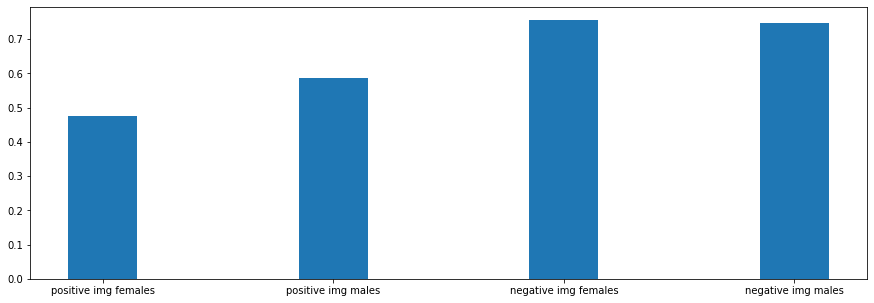

In [39]:
labels = ['positive img females', 'positive img males', 'negative img females', 'negative img males']
values = [piv_females, piv_males, niv_females, niv_males]

y_pos = np.arange(len(labels))

plt.figure(figsize=(15, 5))
plt.bar(y_pos, values, align='center', alpha=1, width=0.3)
plt.xticks(y_pos, labels)

plt.show()

WNIOSEK: Przy negatywnym obrazku nie ma zauważalnych różnic między płciami. W przypadku pozytywnego obrazka mężczyzni wykazują większe zadowolenie niż kobiety. Potwierdza to tezę, że mężczyźni są wzrokowcami.

### Analiza powyższych przyadków odrzucając niektóre wyniki
Odrzucono wyniki, które znajdowały się w odległości $0.1$ od $0$, z uwagi na przypuszcze o ich złej jakości (Мэтью)

In [40]:
def filter_responses(df, interval=-1):    
    responses = list(map(lambda x: x, df.loc[:,"response"]))
    filtered_responses = list(filter(lambda v: -interval > v[0] or v[0] > interval, responses))
    print(f'Odrzucono {100 - (len(filtered_responses) / len(responses) * 100):.2f}% wszystkich odpowiedzi.')
    return filtered_responses

interval = 0.1

In [41]:
filtered_piv = filter_responses(df_pi_ns, interval)
filtered_piv_percentage = sum(list(map(lambda x: 1 if x[0] >= 0 else 0 , filtered_piv))) / len(filtered_piv)

f'{filtered_piv_percentage * 100:.2f}% - odsetek przypadków, w których pozytywny obrazek wywołał zadowolenie'

Odrzucono 27.54% wszystkich odpowiedzi.


'48.93% - odsetek przypadków, w których pozytywny obrazek wywołał zadowolenie'

In [42]:
filtered_niv = filter_responses(df_ni_ps, interval)
filtered_niv_percentage = sum(list(map(lambda x: 1 if x[0] < 0 else 0 , filtered_niv))) / len(filtered_niv)

f'{filtered_niv_percentage * 100:.2f}% - odsetek przypadków, w których negatywny obrazek wywołał niezadowolenie'

Odrzucono 15.92% wszystkich odpowiedzi.


'83.36% - odsetek przypadków, w których negatywny obrazek wywołał niezadowolenie'

In [43]:
filtered_piv_females = filter_responses(df_pi_ns_females, interval)
filtered_piv_females_percentage = sum(list(map(lambda x: 1 if x[0] >= 0 else 0 , filtered_piv_females))) / len(filtered_piv_females)

f'{filtered_piv_females_percentage * 100:.2f}% - odsetek przypadków wśród kobiet, w których pozytywny obrazek wywołał zadowolenie'

Odrzucono 26.65% wszystkich odpowiedzi.


'41.33% - odsetek przypadków wśród kobiet, w których pozytywny obrazek wywołał zadowolenie'

In [44]:
filtered_piv_males = filter_responses(df_pi_ns_males, interval)
filtered_piv_males_percentage = sum(list(map(lambda x: 1 if x[0] >= 0 else 0 , filtered_piv_males))) / len(filtered_piv_males)

f'{filtered_piv_males_percentage * 100:.2f}% - odsetek przypadków wśród mężczyzn, w których pozytywny obrazek wywołał zadowolenie'

Odrzucono 27.90% wszystkich odpowiedzi.


'52.07% - odsetek przypadków wśród mężczyzn, w których pozytywny obrazek wywołał zadowolenie'

In [45]:
filtered_niv_females = filter_responses(df_ni_ps_females, interval)
filtered_niv_females_percentage = sum(list(map(lambda x: 1 if x[0] < 0 else 0 , filtered_niv_females))) / len(filtered_niv_females)

f'{filtered_niv_females_percentage * 100:.2f}% - odsetek przypadków wśród kobiet, w których negatywny obrazek wywołał niezadowolenie'

Odrzucono 15.02% wszystkich odpowiedzi.


'85.22% - odsetek przypadków wśród kobiet, w których negatywny obrazek wywołał niezadowolenie'

In [46]:
filtered_niv_males = filter_responses(df_ni_ps_males, interval)
filtered_niv_males_percentage = sum(list(map(lambda x: 1 if x[0] < 0 else 0 , filtered_niv_males))) / len(filtered_niv_males)

f'{filtered_niv_males_percentage * 100:.2f}% - odsetek przypadków wśród mężczyzn, w których negatywny obrazek wywołał niezadowolenie'

Odrzucono 16.31% wszystkich odpowiedzi.


'82.55% - odsetek przypadków wśród mężczyzn, w których negatywny obrazek wywołał niezadowolenie'

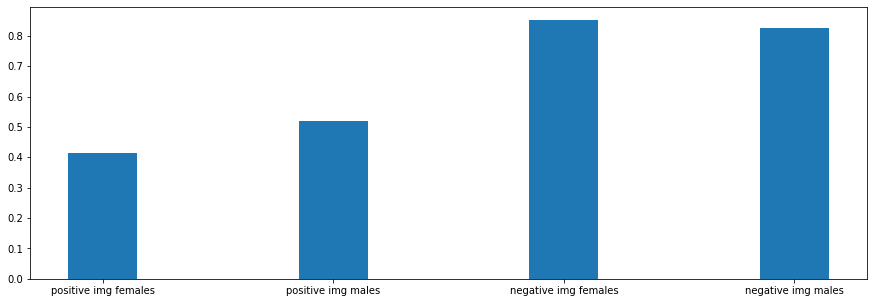

In [47]:
labels = ['positive img females', 'positive img males', 'negative img females', 'negative img males']
values = [filtered_piv_females_percentage, filtered_piv_males_percentage, filtered_niv_females_percentage, filtered_niv_males_percentage]

y_pos = np.arange(len(labels))

plt.figure(figsize=(15, 5))
plt.bar(y_pos, values, align='center', alpha=1, width=0.3)
plt.xticks(y_pos, labels)

plt.show()

WNIOSEK: Wpływ negatywnego obrazka na negatywny wynik zadowolenia jest dużo większy. Kobiety bardziej zwracają uwagę (względem odgłosów) na obrazki negatywne, zaś mężczyźni na obrazki pozytywne.